In [23]:
# Expectation Maximization for a coin toss and data generator
# adapted/augmented based on K. Rosaen 
# Here simplified: ASSUMPTION each coin will be thrown with prob=1/2
# With Data generation unit and theoretical optimum, Jan Nagler

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

#EM algorithm, max_iter set here
def coin_em(rolls, theta_A=None, theta_B=None, max_iter=10):
    
    # Initial Guess
    theta_A = theta_A or random.random() #take value or start wild between 0 and 1
    theta_B = theta_B or random.random()
    
    # theta vector
    thetas = [(theta_A, theta_B)]
    
    # Iterate
    for i in range(max_iter):
        print("#%d:\t%0.3f %0.3f" % (i, theta_A, theta_B)) #significant digits 
        heads_A, tails_A, heads_B, tails_B = e_step( rolls, theta_A, theta_B )
        theta_A, theta_B = m_step( heads_A, tails_A, heads_B, tails_B )
        
    thetas.append((theta_A,theta_B))    
    return thetas, (theta_A,theta_B)

# Compute expected value for heads_A, tails_A, heads_B, tails_B over rolls given coin biases
def e_step( rolls, theta_A, theta_B ):
    
    heads_A, tails_A = 0,0
    heads_B, tails_B = 0,0
    
    for trial in rolls:
        likelihood_A = coin_likelihood( trial, theta_A )
        likelihood_B = coin_likelihood( trial, theta_B )
        p_A = likelihood_A / ( likelihood_A + likelihood_B )
        p_B = likelihood_B / ( likelihood_A + likelihood_B )
        heads_A += p_A * trial.count("H")
        tails_A += p_A * trial.count("T")
        heads_B += p_B * trial.count("H")
        tails_B += p_B * trial.count("T") 
        
    return heads_A, tails_A, heads_B, tails_B

# M step: Compute values for theta that maximize the expected number of heads/tails
def m_step(heads_A, tails_A, heads_B, tails_B):
    
    #theta_A = heads_A / (heads_A + tails_A)
    #theta_B = heads_B / (heads_B + tails_B)
    theta_A = np.divide( heads_A, heads_A + tails_A ) #better: avoids divby0s
    theta_B = np.divide( heads_B, heads_B + tails_B )
    
    return theta_A, theta_B

# p(X | Z, theta)
def coin_likelihood(roll, bias):
    numHeads = roll.count("H")
    flips = len(roll)
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads)

In [24]:
# plot EM convergence
def plot_coin_likelihood(rolls, thetas=None):
    # grid
    xvals = np.linspace(0.01,0.99,100)
    yvals = np.linspace(0.01,0.99,100)
    X,Y = np.meshgrid(xvals, yvals)
    
    # compute likelihood
    Z = []
    for i,r in enumerate(X):
        z = []
        for j,c in enumerate(r):
            z.append(coin_marginal_likelihood(rolls,c,Y[i][j]))
        Z.append(z)
    
    # plot
    plt.figure(figsize=(10,8))
    C = plt.contour(X,Y,Z,150)
    cbar = plt.colorbar(C)
    plt.title(r"Likelihood $\log p(\mathcal{X}|\theta_A,\theta_B)$", fontsize=20)
    plt.xlabel(r"$\theta_A$", fontsize=20)
    plt.ylabel(r"$\theta_B$", fontsize=20)
    
    # plot thetas
    if thetas is not None:
        thetas = np.array(thetas)
        plt.plot(thetas[:,0], thetas[:,1], '-k', lw=2.0)
        plt.plot(thetas[:,0], thetas[:,1], 'ok', ms=5.0)
        
# log P(X | theta), only used for plot
def coin_marginal_likelihood( rolls, biasA, biasB ):
    trials = []
    for roll in rolls:
        h = roll.count("H")
        t = roll.count("T")
        likelihoodA = coin_likelihood(roll, biasA)
        likelihoodB = coin_likelihood(roll, biasB)
        trials.append(np.log(0.5 * (likelihoodA + likelihoodB)))
    return sum(trials)

In [28]:
# Generate surrogate data
import random

# Number of experiments
experiments = 6

# Number of coin tosses for each trial
coin_tosses = 50

# Experiment properties: Prob to choose coin A for the trial
pA = 0.5
pB = 1-pA
# Coin properties: Prob for heads and tails
p_heads_A = 0.99999
p_heads_B = 0.666666

# empty array where all tosses are stored
rolls= []

A_heads = 0
B_heads = 0
A_tails = 0
B_tails = 0

for i in range(0,experiments):
    trial = ""
    A=0
    # Choose coin: p fixed for single trial
    if ( random.uniform(0, 1) < pA ): 
        p = p_heads_A
        A=1
    else:
        p = p_heads_B
        A=0
        
    for j in range(0,coin_tosses):
        # generate outcome
        outcome = random.uniform(0, 1)
        if (outcome < p): 
            trial += "H"
            if (A==1): 
                A_heads += 1
            else:
                B_heads += 1
        else: 
            trial += "T"
            if (A==1): 
                A_tails += 1
            else:
                B_tails += 1
    rolls.append( trial ) 
    
#print entire outcomes of experiment     
print(rolls)

# Call EM
thetas, _ = coin_em( rolls, 0.8, 0.5, max_iter=10 )

# Compare with  
print("MLE estimates from data (finite sample size estimates are the theoretical optimum!):")
MLE_pA, MLE_pB = m_step( A_heads, A_tails, B_heads, B_tails )
print("%0.3f %0.3f" % (MLE_pA, MLE_pB))
#print(round(MLE_pA,3), round(MLE_pB,3))

['THHHHHHHHHTHHHHHHTHHTHHHHTTHTHHHHTHTHTTHHHHHTHTHHT', 'HHHHTHTHHHTHTHTTHHTHHHHTHHHTHHTTHHTTHHHTHHHTTTHHTT', 'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH', 'HHHTTTTTTHHHHTHTTHHHHHHHTTHHHTHTTTHHHTHTHTHHHHTHHT', 'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH', 'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH']
#0:	0.800 0.500
#1:	0.925 0.611
#2:	1.000 0.647
#3:	1.000 0.647
#4:	1.000 0.647
#5:	1.000 0.647
#6:	1.000 0.647
#7:	1.000 0.647
#8:	1.000 0.647
#9:	1.000 0.647
MLE estimates from data (finite sample size estimates are the theoretical optimum!):
1.000 0.647
1.0 0.647


how EM got there...


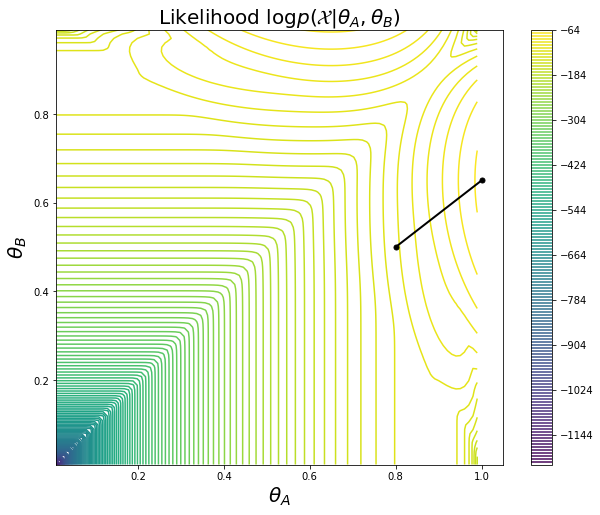

In [26]:
print("how EM got there...")
plot_coin_likelihood(rolls, thetas)